In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 10.0)

### data set reading

In [2]:
df = pd.read_csv('../input/apple-aapl-historical-stock-data/HistoricalQuotes.csv')
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,02/28/2020,$273.36,106721200,$257.26,$278.41,$256.37
1,02/27/2020,$273.52,80151380,$281.1,$286,$272.96
2,02/26/2020,$292.65,49678430,$286.53,$297.88,$286.5
3,02/25/2020,$288.08,57668360,$300.95,$302.53,$286.13
4,02/24/2020,$298.18,55548830,$297.26,$304.18,$289.23


### preprocessing data set to perform analysis

In [3]:
df.shape

(2518, 6)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         2518 non-null   object
 1    Close/Last  2518 non-null   object
 2    Volume      2518 non-null   int64 
 3    Open        2518 non-null   object
 4    High        2518 non-null   object
 5    Low         2518 non-null   object
dtypes: int64(1), object(5)
memory usage: 118.2+ KB


In [5]:
df1 = df.iloc[:,1]
df1.head()

0     $273.36
1     $273.52
2     $292.65
3     $288.08
4     $298.18
Name:  Close/Last, dtype: object

In [6]:
df1.tail()

2513     $31.2786
2514     $30.1014
2515     $29.9043
2516     $29.8357
2517     $29.8557
Name:  Close/Last, dtype: object

In [7]:
df1 = df1.replace('[\$,]', '', regex=True).astype(float)
df1.head()

0    273.36
1    273.52
2    292.65
3    288.08
4    298.18
Name:  Close/Last, dtype: float64

Text(0, 0.5, 'stock price')

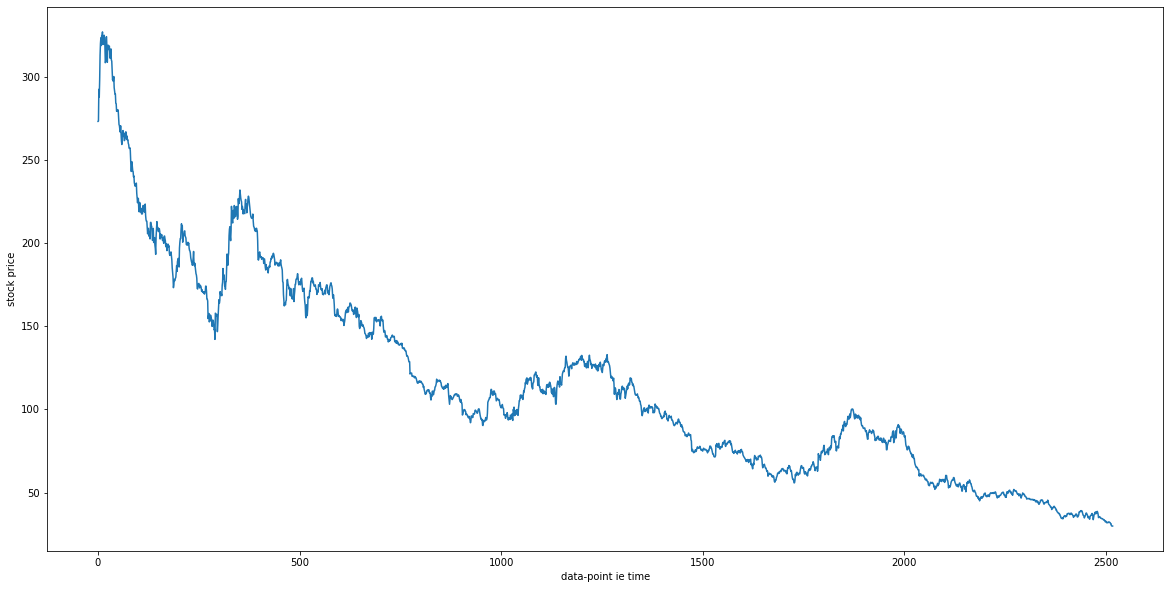

In [8]:
plt.plot(df1)
plt.xlabel("data-point ie time")
plt.ylabel("stock price")

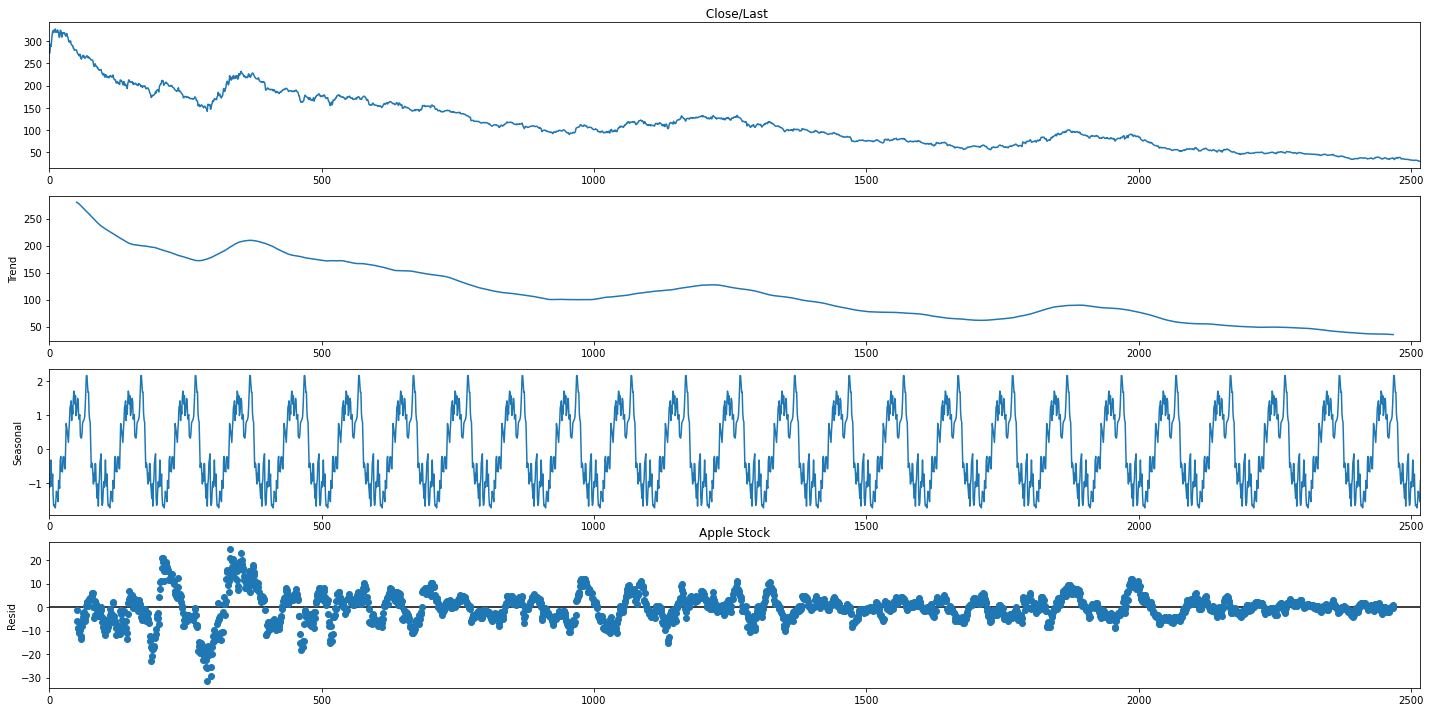

In [9]:
#show the components of this time series
from statsmodels.tsa.seasonal import seasonal_decompose

result  = seasonal_decompose(pd.Series(df1),period=100)

result.plot()
plt.title('Apple Stock')
plt.show()

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

In [11]:
df1.shape

(2518,)

In [12]:
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [13]:
print(df1)
print('\n df1 present shape : ', df1.shape)

[[8.18942624e-01]
 [8.19480684e-01]
 [8.83812549e-01]
 ...
 [2.30693463e-04]
 [0.00000000e+00]
 [6.72575693e-05]]

 df1 present shape :  (2518, 1)


### splitting data (70/30)

In [14]:
training_size = int(len(df1)*0.7)
test_size = len(df1) - training_size
print('Training Size : ',training_size)
print('Test Size : ',test_size)

Training Size :  1762
Test Size :  756


In [15]:
train_data, test_data = df1[0:training_size,:],df1[training_size:len(df1),:]
print('Training Data Shape : ', train_data.shape)
print('Test Data Shape: ', test_data.shape)

Training Data Shape :  (1762, 1)
Test Data Shape:  (756, 1)


### | windowing data set |

In [16]:
def create_dataset(dataset, window=1):
    dataX, dataY= [], []
    for i in range(len(dataset)-window-1):
        a = dataset[i:(i+window),0]
        dataX.append(a)
        dataY.append(dataset[i+window,0])
    return np.array(dataX), np.array(dataY)

In [17]:
window = 100
X_train, y_train = create_dataset(train_data, window=100)
X_test, y_test = create_dataset(test_data, window=100)

In [18]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1661, 100) (1661,)
(655, 100) (655,)


In [19]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

### lstm coding

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [21]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer = 'adam')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


### fitting data to model

In [23]:
model.fit(X_train,y_train,validation_data = (X_test,y_test), epochs = 100, batch_size=64,verbose=1)

Epoch 1/100
26/26 [==============================] - 7s 64ms/step - loss: 0.0381 - val_loss: 0.0053
Epoch 2/100
26/26 [==============================] - 0s 18ms/step - loss: 0.0015 - val_loss: 1.1476e-04
Epoch 3/100
26/26 [==============================] - 0s 17ms/step - loss: 4.6910e-04 - val_loss: 1.2754e-04
Epoch 4/100
26/26 [==============================] - 0s 17ms/step - loss: 4.7724e-04 - val_loss: 1.2879e-04
Epoch 5/100
26/26 [==============================] - 0s 17ms/step - loss: 5.3050e-04 - val_loss: 1.0386e-04
Epoch 6/100
26/26 [==============================] - 0s 17ms/step - loss: 4.5003e-04 - val_loss: 1.1487e-04
Epoch 7/100
26/26 [==============================] - 0s 17ms/step - loss: 4.4173e-04 - val_loss: 1.1638e-04
Epoch 8/100
26/26 [==============================] - 0s 17ms/step - loss: 4.5176e-04 - val_loss: 1.0012e-04
Epoch 9/100
26/26 [==============================] - 0s 17ms/step - loss: 3.9638e-04 - val_loss: 1.1037e-04
Epoch 10/100
26/26 [====================

In [24]:
y_pred = scaler.inverse_transform(model.predict(X_test))

In [25]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [26]:
y_pred[:5]

array([[93.37183 ],
       [94.230965],
       [94.368225],
       [94.34008 ],
       [94.78538 ]], dtype=float32)

In [27]:
y_test[:5]

array([[94.4728],
       [94.1985],
       [95.3007],
       [97.3314],
       [95.0257]])

### evaluation

In [28]:
import math
from sklearn.metrics import mean_squared_error

rmse_score = math.sqrt(mean_squared_error(y_test,y_pred))
print('Root Mean Squared Error(test) : ',rmse_score)

Root Mean Squared Error(test) :  1.4853871963289433


In [29]:
from sklearn.metrics import r2_score
print('R-squared Score  : ',r2_score(y_test,y_pred))

R-squared Score  :  0.9936639083093958


### visualization + plotting

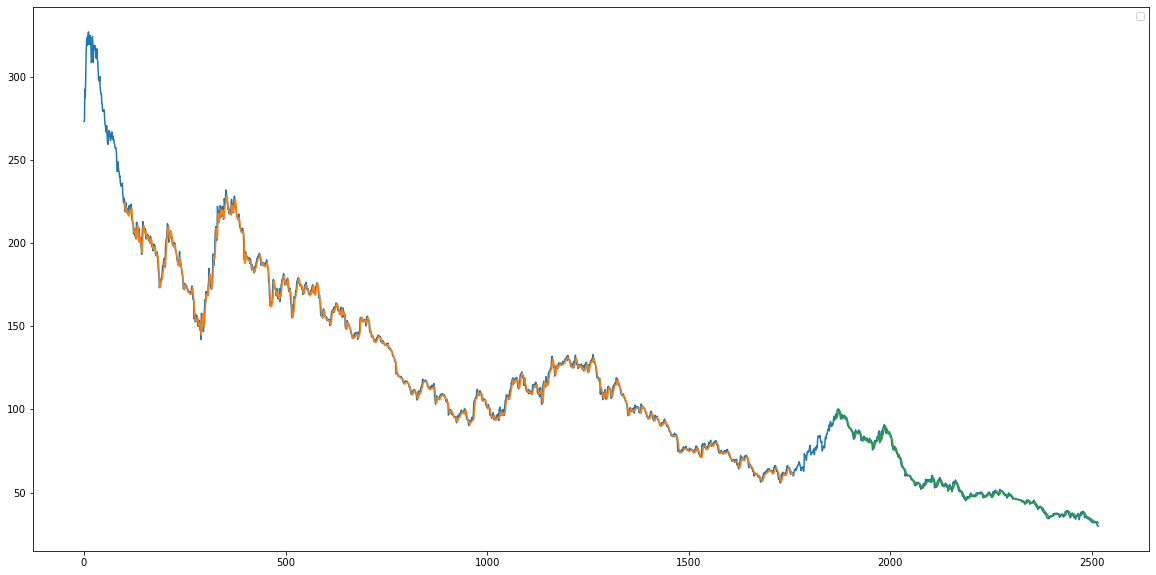

In [30]:
# shift train predictions for plotting
train_predict = scaler.inverse_transform(model.predict(X_train))

look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = y_pred
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend()
plt.show()

### predicting 30 Days future value

In [31]:
x_input=test_data[len(test_data)-100:].reshape(1,-1)
x_input.shape

(1, 100)

In [32]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [33]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

#print(lst_output)

In [34]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [35]:
print(scaler.inverse_transform(lst_output))

[[31.12888162]
 [30.99278951]
 [31.00769938]
 [31.11149007]
 [31.25259941]
 [31.40033278]
 [31.54060422]
 [31.66912432]
 [31.78617555]
 [31.89363781]
 [31.99359797]
 [32.08787321]
 [32.17791996]
 [32.26486704]
 [32.34957421]
 [32.43268397]
 [32.51465052]
 [32.59578126]
 [32.67625454]
 [32.75615399]
 [32.83549291]
 [32.9142425 ]
 [32.99234072]
 [33.0697189 ]
 [33.14631055]
 [33.22205255]
 [33.29690003]
 [33.3708203 ]
 [33.44379454]
 [33.51581333]]


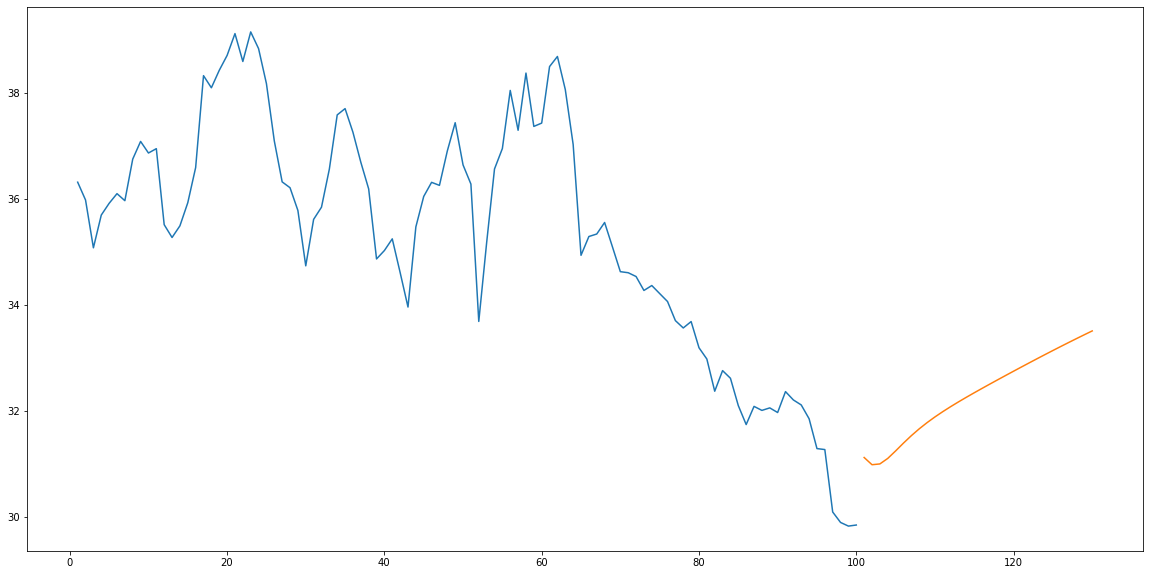

In [36]:
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))